# <center> **Project 2** <center/>

<center>
Author: Omar Gabr <br>
Digit of Interest: $2$
<center/>

# <center> **Pre-Loading Data**  <center/>

### Import Dataset


In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving train-images.idx3-ubyte to train-images.idx3-ubyte
Saving train-labels.idx1-ubyte to train-labels.idx1-ubyte


In [ ]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7919 sha256=21be37190d3f7278521549efcf1aba511f6022a635d5d8e15d4df6b4ddaa516c
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


### Modules

In [ ]:
# data processing
import idx2numpy
import numpy as np 
import pandas as pd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sms

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Data Collection

In [ ]:
# Splitting data into train and test sets
X_file = '/content/train-images.idx3-ubyte'
y_file = '/content/train-labels.idx1-ubyte'

X = idx2numpy.convert_from_file(X_file)
y = idx2numpy.convert_from_file(y_file)

print(X.shape, y.shape)
print(np.unique(y))

(60000, 28, 28) (60000,)
[0 1 2 3 4 5 6 7 8 9]


### Visualize Sample for Verification

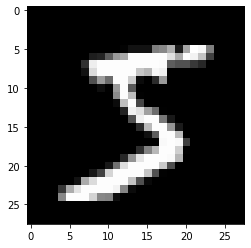

In [ ]:
# Double check that data is pre-loaded properly
fig, ax = plt.subplots()
ax.imshow(X[0], cmap='gray')

# <center> **Part 1** <center/>
In this section, I will be coding a least-squares binary classifier for the handwritten MNIST digit dataset. Based on my digit of interest, this classifier will determine whether an image, $x$, is the digit $2$ or not.
<br>
<br/>
This model will include two parameters, the intercept $\beta_0$ and slope $\beta$, that will help build our classifier. If an image is recognized as the target, then it will be labeled as $1$, and $-1$ otherwise, as such:

<center>$\begin{equation}
y_i = 
\left\{
    \begin{array}{lr}
        1: \beta_0+\beta_i^T x_i \geq 0\\
        -1: \beta_0+\beta_i^T x_i < 0
    \end{array}
\right\}
\end{equation}$ <center/>

Now, we can design our least-squares function as the following which uses the residual sum of squares (RSS) technique:
<center> $\text{argmin}_{\beta} = \sum^N_{i=0} (y_i - \beta_i^T x_i)^2$ <center/>

Where $N$ represents the number of data points in our set, and that we want to minimize the residual error with respect to the weighted components. From here, we can perform some linear algebra operations to arrive at the well-known normal equation:
<center> $\beta_i = (x_i^Tx_i)^{-1}x_i^Ty_i $ <center/>

And with this, we can estimate our intercept and coefficient to build the classifier in the next section of this part.

Firstly, I will extract the indices of all digits with label $2$, and similarly for digits other than $2$, then I will sample both datasets into equally-split training and testing sets.

In [ ]:
# Function returns numpy binary label array
# 1 indicates correct_digit, -1 indicates otherwise
def convert_y_to_binary(y, correct_digit):
    return np.where(y == correct_digit,
                    np.ones_like(y, dtype=np.int8),
                    -1 * np.ones_like(y)).reshape(y.size, 1)

# Execute function on y data
y_2 = convert_y_to_binary(y, 2)

print('y Shape After Label Encoding', y_2.shape)  # should retain same # of observations, but just one column

y Shape After Label Encoding (60000, 1)


This extraction step is needed to properly distinguish the labels between the digit of interest and all other digits. That way when the digit is recognized correctly, it will display as $1$, and $-1$ otherwise. Furthermore, this is how the classifier will predict the correct digit.

In [ ]:
# Train/Test split into equal sizes
# Make sure to see this code block
X_train, X_test, y_train, y_test = train_test_split(X, y_2, test_size=0.5, random_state=1)  # default setting performs random splitting

y_test = y_test.squeeze()
y_train = y_train.squeeze()

print('Training Shape (X, y):', X_train.shape, y_train.shape)
print('Testing Shape (X, y)', X_test.shape, y_test.shape)

Training Shape (X, y): (30000, 28, 28) (30000,)
Testing Shape (X, y) (30000, 28, 28) (30000,)


Secondly, I will extract the coefficient $\beta$ and intercept $\beta_0$ attributes using sklearn's Linear Regression model.

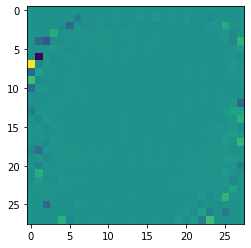

In [ ]:
# Perform Linear Regression and Fit Model
X_train = X_train.reshape(X_train.shape[0], 28*28)    # reshape into 2 dimensions for ml model
X_test = X_test.reshape(X_test.shape[0], 28*28)

model = sms.OLS(y_train, X_train).fit()
beta = model.params
beta_0 = model.params[0]

# Visualize Beta as a 2D image -- 28x28 pixels
beta = beta.reshape((28, 28))   # reshape back into image
plt.imshow(beta)

Given the classifier model, I will examine the classification error rate for the train and test sets represented as:
<center> $\text{class error} = \frac{1}{N} \sum^{N}_{i=0}(y_i \ne \hat{y_i}) $ <center/>

In [ ]:
# Classifier
def classifier(narray):
  narray[narray>=0e-5] = 1
  narray[narray<0e-5] = -1
  return narray

# Classification Error Rate
y_predictions = model.predict(X_test)
y_pred_sub = y_predictions.copy()   # create for future use
y_predictions_train = model.predict(X_train)

# Classify Predictions Based on Sign
y_predictions = classifier(y_predictions)
y_predictions_train = classifier(y_predictions_train)

# Compute Rate
train_class_error_rate = np.abs(np.mean(y_train - y_predictions_train))
test_class_error_rate = np.abs(np.mean(y_test - y_predictions))

class_error_df = pd.DataFrame({'Classification Train Rate': train_class_error_rate, 'Classification Test Rate': test_class_error_rate}, index=[1])

class_error_df

,Classification Train Rate,Classification Test Rate
1,0.048733,0.050333


Similarly to the train and test sets, I will also compute a confusion matrix to better evaluate the binary classifier model.

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

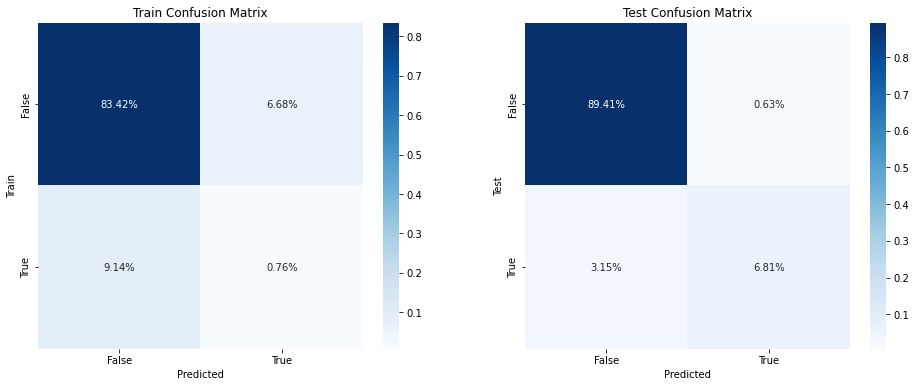

In [ ]:
# Confusion Matrix
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))

# Training
confusion_train = confusion_matrix(y_train, y_predictions)
sns.heatmap((confusion_train/np.sum(confusion_train)), fmt='.2%', annot=True, cmap='Blues', ax=axs[0])

axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Train')
axs[0].set_title('Train Confusion Matrix')
axs[0].xaxis.set_ticklabels(['False','True'])
axs[0].yaxis.set_ticklabels(['False','True'])


# Testing
confusion_test = confusion_matrix(y_test, y_predictions)
sns.heatmap((confusion_test/np.sum(confusion_test)), fmt='.2%', annot=True, cmap='Blues', ax=axs[1])

axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Test')
axs[1].set_title('Test Confusion Matrix')
axs[1].xaxis.set_ticklabels(['False','True'])
axs[1].yaxis.set_ticklabels(['False','True'])

Finally, seeing how there are significant weights in the parameter vector, I will attempt to reduce the number of parameters by using the backward selection method. 

In [ ]:
# Backward Elimination for Feature Selection
# Method: 
pvals = model.pvalues
sig_pvals = pvals[pvals>0]    # eliminating pixels with value 0
sig_pvals.shape

#backward_elim = RFE(estimator=LinearRegression(), n_features_to_select=50).fit(X_train, y_train)

# Visualize Beta for the reduced model
#plt.imshow()

(762,)

Below is a series of diagnostic tests for the purpose of exploratory data analysis into the least-squares regression.

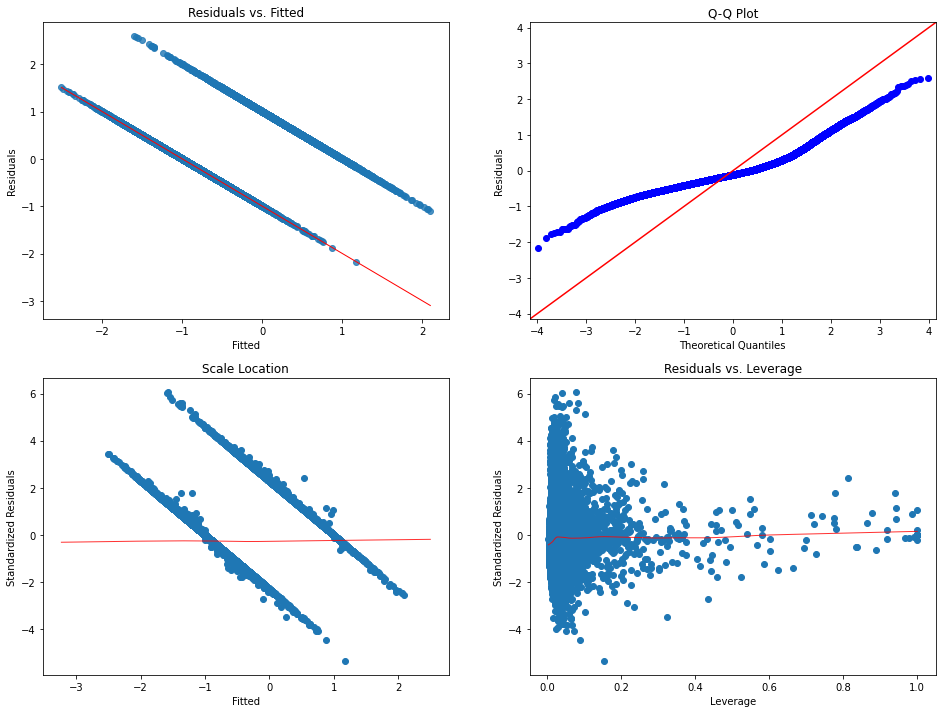

In [ ]:
# Subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))


# Residuals vs Fitted
residuals = model.resid
sns.regplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 1}, ax=axs[0, 0])
axs[0, 0].set_xlabel('Fitted')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].set_title('Residuals vs. Fitted')


# Normal Q-Q Plot
sms.qqplot(residuals, line='45', ax=axs[0, 1])
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].set_title('Q-Q Plot')


# Scale-Location
norm_residuals = model.get_influence().resid_studentized_internal
axs[1, 0].scatter(model.fittedvalues, norm_residuals)
sns.regplot(y_pred_sub, norm_residuals, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axs[1, 0])
axs[1, 0].set_xlabel('Fitted')
axs[1, 0].set_ylabel('Standardized Residuals')
axs[1, 0].set_title('Scale Location')


# Residuals vs. Leverage
leverage = model.get_influence().hat_matrix_diag
axs[1, 1].scatter(leverage, norm_residuals)
sns.regplot(leverage, norm_residuals, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=axs[1, 1])
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Standardized Residuals')
axs[1, 1].set_title('Residuals vs. Leverage')


# Show Plots
plt.show()


### Analysis: 

Make sure to say something here about the diagnostic plots.

# <center> **Part 2** <center/>

In this part, I will set the training and testing sets for each digit and compute the classification error rate for each. Additionally, I will be storing the restulting rates into a triangular matrix, where the training error rates will be displayed upper triangle, and the testing rates in the lower triangle portions.

In [ ]:
# Create list of lists where each list contains n digits
y_digits = np.array([])

y0 = y[y==0]
y1 = y[y==1]
y2 = y[y==2]
y3 = y[y==3]
y4 = y[y==4]
y5 = y[y==5]
y6 = y[y==6]
y7 = y[y==7]
y8 = y[y==8]
y9 = y[y==9]

y_digits = np.append(y_digits, [y0, y1, y2, y3, y4, y5, y6, y7, y8, y9])


# Function returns fitted values of ols model
# Input is X_train and y_train of given set
def ols_predictor(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
  y_train, y_test = y_train.squeeze(), y_test.squeeze()
  X_train, X_test = X_train.reshape(X_train.shape[0], 28*28), X_test.reshape(X_test.shape[0], 28*28)
  model = sms.OLS(y_train, X_train).fit()
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  return y_pred_train, y_pred_test


# Function returns classification error rate
# Inputs are two arrays: fittedvalues and actual values
def class_error_funct(estimates, actual):
  # Pass through classifier function
  estimates = classifier(estimates)
  # Compute error rate
  error_rate = np.abs(np.mean(actual - estimates))
  return error_rate


# Extract indices to create mask for images dataset
indices = [[] for x in range(10)]
for i in range(y.shape[0]):
  for j in range(10):
    if (y[i] == j):
      indices[j].append(i)
indices = np.array(indices, dtype='object')


# Mask for Images Data
masked_X = [[] for x in range(10)]
for i in range(10):
  masked_X[i].append(X[indices[i]])

# Function returns triangular matrix of classification error ratese
# upper triangle represents the training error rates
# lower triangle represents the testing error rates
# diaganol entries are NA
def triang_error_mat(matrix, X, y, y_digits, masked_X):
  for i in range(10):
    for j in range(10):
      if (i==j):
        triangular_class_error_matrix[i][j] = 'NA'
      elif (i < j):   # upper triangle
        # Join both images dataset for digit vs digit
        X = np.concatenate((masked_X[i][0], masked_X[j][0]), axis=0)
        # combine digit vs digit to perform regression
        y = np.concatenate((y_digits[i], y_digits[j]))
        y = convert_y_to_binary(y, i)
        y_pred_train, y_pred_test = ols_predictor(X, y)
        # pass train values through class error rate function
        train_error_rate = class_error_funct(y_pred_train, y)
        # append value into i,j slot
        triangular_class_error_matrix[i].insert(j, train_error_rate)
      else:
        # Join both images dataset for digit vs digit
        X = np.concatenate((masked_X[i][0], masked_X[j][0]), axis=0)
        # combine digit vs digit to perform regression
        y = np.concatenate((y_digits[i], y_digits[j]))
        y = convert_y_to_binary(y, i)
        y_pred_train, y_pred_test = ols_predictor(X, y)
        # pass train values through class error rate function
        test_error_rate = class_error_funct(y_pred_test, y)
        # append value into i,j slot
        triangular_class_error_matrix[i].insert(j, test_error_rate)
  return triangular_class_error_matrix


# Print
print('Verify Same Shapes for Corresponding Indices and Labels', len(indices[0]), y0.shape)

Verify Same Shapes for Corresponding Indices and Labels 5923 (5923,)


In [ ]:
# Create 10x10 matrix for triang error rate
triangular_class_error_matrix = [[1]*10 for x in range(10)]
triangular_class_error_matrix = triang_error_mat(triangular_class_error_matrix, X, y, y_digits, masked_X)

# Convert data into DataFrame object
triangular_df = pd.DataFrame(triangular_class_error_matrix)
triangular_df = triangular_df.iloc[:, :10]

print(triangular_df.shape)

(10, 10)


Classification Error Rate Triangluar Matrix of Training and Testing Data for All Digits

In [ ]:
triangular_df.index.name = 'Digit'
triangular_df

,0,1,2,3,4,5,6,7,8,9
Digit,,,,,,,,,,
0,NA,0.013666,0.015236,0.016758,0.022866,0.016749,0.019679,0.013292,0.023611,0.01533
1,0.00939,NA,0.004094,0.001783,0.006357,0.00254,0.006951,0.005308,0.016603,0.00559
2,0.015065,0.005669,NA,0.007529,0.032203,0.013619,0.029303,0.009411,0.040904,0.021418
3,0.014103,0.001635,0.012654,NA,0.01946,0.01437,0.017346,0.015328,0.026874,0.006126
4,0.019633,0.009854,0.027797,0.020964,NA,0.010208,0.021769,0.007189,0.013599,0.023326
5,0.008639,0.003051,0.003255,0.011946,0.004709,NA,0.023024,0.015574,0.00692,0.007564
6,0.014102,0.010111,0.041765,0.023155,0.026531,0.044705,NA,0.012398,0.026767,0.017445
7,0.005415,0.002232,0.001556,0.017586,0.009501,0.019339,0.005989,NA,0.013041,0.026036
8,0.016477,0.0285,0.053261,0.026206,0.01753,0.00692,0.023195,0.01271,NA,0.015424


# <center> **Part 3** <center/>
In this part, I will be executing the logistic regression model for the results discussed in *Part 1* and *Part 2*.
<br> <br/>
First, I will repreat *Part 1* while performing Logistic Regression instead of Linear.

In [ ]:
# Retrain/retest for new model
X = idx2numpy.convert_from_file(X_file)
X_train, X_test, y_train, y_test = train_test_split(X, y_2, test_size=0.5, random_state=5)
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# Perform logisitic regression and extract predictions on both train/test
logistic_model = LogisticRegression().fit(X_train, y_train)
logistic_y_train_pred = logistic_model.predict(X_train)   # train predictions
logistic_y_test_pred = logistic_model.predict(X_test)     # test predictions
beta = logistic_model.coef_

# Run fitted values through classifier function
logistic_train_error_2 = np.abs(np.mean(y_2 - logistic_y_train_pred))
logistic_test_error_2 = np.abs(np.mean(y_2 - logistic_y_test_pred))
logistic_error_2_df = pd.DataFrame({'Classification Train Rate': logistic_train_error_2, 'Classification Test Rate': logistic_test_error_2}, index=[1])


logistic_error_2_df   # Digit = 2

,Classification Train Rate,Classification Test Rate
1,0.008067,0.0136


Now, to repeat *Part 2* with logistic regression as well.

In [ ]:
# Function returns fitted values of logistic regression
# similar to ols_predictor, but only different model
def logistic_predictor(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
  y_train, y_test = y_train.squeeze(), y_test.squeeze()
  X_train, X_test = X_train.reshape(X_train.shape[0], 28*28), X_test.reshape(X_test.shape[0], 28*28)
  model = LogisticRegression().fit(X_train, y_train)    # apply logistic instead of linear
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  return y_pred_train, y_pred_test

triangular_logistic_error_matrix = [[1]*10 for x in range(10)]
triangular_logistic_error_matrix = triang_error_mat(triangular_logistic_error_matrix, X, y, y_digits, masked_X)

# Convert data into DataFrame object
triangular_logistic_df = pd.DataFrame(triangular_logistic_error_matrix)
triangular_logistic_df = triangular_logistic_df.iloc[:, :10]

print(triangular_logistic_df.shape)

(10, 10)


In [ ]:
triangular_logistic_df.index.name = 'Digit'
triangular_logistic_df

,0,1,2,3,4,5,6,7,8,9
Digit,,,,,,,,,,
0,NA,0.013666,0.015236,0.016758,0.022866,0.016749,0.019679,0.013292,0.023611,0.01533
1,0.00939,NA,0.004094,0.001783,0.006357,0.00254,0.006951,0.005308,0.016603,0.00559
2,0.015065,0.005669,NA,0.007529,0.032203,0.013619,0.029303,0.009411,0.040904,0.021418
3,0.014103,0.001635,0.012654,NA,0.01946,0.01437,0.017346,0.015328,0.026874,0.006126
4,0.019633,0.009854,0.027797,0.020964,NA,0.010208,0.021769,0.007189,0.013599,0.023326
5,0.008639,0.003051,0.003255,0.011946,0.004709,NA,0.023024,0.015574,0.00692,0.007564
6,0.014102,0.010111,0.041765,0.023155,0.026531,0.044705,NA,0.012398,0.026767,0.017445
7,0.005415,0.002232,0.001556,0.017586,0.009501,0.019339,0.005989,NA,0.013041,0.026036
8,0.016477,0.0285,0.053261,0.026206,0.01753,0.00692,0.023195,0.01271,NA,0.015424


### Analysis:
It can be seen by comparing the classification error rates between the both linear and logistic regression that logistic performs much better. <br>
**Which digits vs. digits for each model outperformed the other?**

# <center> **Part 4** <center/>

In [ ]:
# Cook's Distance
# 10 groups for each digit to measure cook's distance
# Digit vs non digit data - similar to y_2 from Part 1
list_y_binary = [[] for x in range(10)]
for i in range(10):
  list_y_binary[i].append(convert_y_to_binary(y, i))

def cooks_distance(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
  model = sms.OLS(y_train, X_train).fit()
  influence = model.get_influence()
  cooks = influence.cooks_distance
  return cooks

# Return list of cooks distance for each digit vs non digit
cooks_list = [[] for x in range(10)]
for i in range(10):
  cooks = cooks_distance(X, list_y_binary[i][0])
  cooks_list[i].append(cooks)


# Function returns cook's distance of a given digit's data set
# Inputs are (1) X, (2) y


print(len(list_y_binary[2][0]))
print(len(cooks_list))

ValueError: ignored